In [61]:
import torch
from torchvision import datasets, transforms
device = "cuda" if torch.cuda.is_available() else "cpu"

In [62]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.RandomHorizontalFlip(p=0.5), # Випадково перевернути по горизонталі з ймовірністю 50%
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)), # Зміна розміру зображення до 256x256 пікселів
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
])

In [63]:
# Створити екземпляр ImageFolder з трансформаціями
dataset_train ="/kaggle/input/fruit-recognition/train/train"
dataset_trains = datasets.ImageFolder(root=dataset_train)

In [64]:
dataset_trains.classes

['Apple Braeburn',
 'Apple Granny Smith',
 'Apricot',
 'Avocado',
 'Banana',
 'Blueberry',
 'Cactus fruit',
 'Cantaloupe',
 'Cherry',
 'Clementine',
 'Corn',
 'Cucumber Ripe',
 'Grape Blue',
 'Kiwi',
 'Lemon',
 'Limes',
 'Mango',
 'Onion White',
 'Orange',
 'Papaya',
 'Passion Fruit',
 'Peach',
 'Pear',
 'Pepper Green',
 'Pepper Red',
 'Pineapple',
 'Plum',
 'Pomegranate',
 'Potato Red',
 'Raspberry',
 'Strawberry',
 'Tomato',
 'Watermelon']

In [65]:
from torch.utils.data import random_split

train_ratio = 0.8

# Розділіть набір даних
train_data, val_data = random_split(dataset_trains, [train_ratio, 1-train_ratio])

In [66]:
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
        
    def __len__(self):
        return len(self.subset)

    
train_data = TransformDataset(train_data, transform = train_transform)
val_data = TransformDataset(val_data, transform = test_transform)

In [67]:
batch_size = 33

# Створіть завантажувачі даних
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=batch_size)

In [68]:
import torchvision
torchvision.models.resnet50(pretrained = True)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [69]:
from torch import nn
import torch.nn.functional as F
import numpy as np


class TransferLearningClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        resnet=torchvision.models.resnet50(pretrained = True) 
        #torchvision.models.inception_v3(pretrained: bool = False
        
        # від'єднання градієнтів
        for param in resnet.parameters():
            param.requires_grad = False
        
        # кількість нейронів на виході
        in_features = resnet.fc.in_features
        
        # деактивація останнього шару
        resnet.fc = nn.Identity()
        
        # створення потрібних шарів
        self.feature_extractor = resnet
        
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Linear(in_features, num_classes)
        

    def forward(self, x):
        out = self.feature_extractor(x)
        
        out = self.dropout(out)
        out = self.linear(out)
        
        return out


    def predict(self, X, device='cpu'):
        X = torch.FloatTensor(np.array(X)).to(device)

        with torch.no_grad():
            y_pred = F.softmax(self.forward(X), dim=-1)

        return y_pred.cpu().numpy()


model = TransferLearningClassifier(len(dataset_trains.classes)).to(device)

In [70]:
!pip install -q torchsummary

In [71]:
from torchsummary import summary

summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [72]:
# @title Функція для тренування
import time

def train(model, optimizer, loss_fn, train_dl, val_dl,
          metrics=None, metrics_name=None, epochs=20, device='cpu', task='regression'):
    '''
    Runs training loop for classification problems. Returns Keras-style
    per-epoch history of loss and accuracy over training and validation data.

    Parameters
    ----------
    model : nn.Module
        Neural network model
    optimizer : torch.optim.Optimizer
        Search space optimizer (e.g. Adam)
    loss_fn :
        Loss function (e.g. nn.CrossEntropyLoss())
    train_dl :
        Iterable dataloader for training data.
    val_dl :
        Iterable dataloader for validation data.
    metrics: list
        List of sklearn metrics functions to be calculated
    metrics_name: list
        List of matrics names
    epochs : int
        Number of epochs to run
    device : string
        Specifies 'cuda' or 'cpu'
    task : string
        type of problem. It can be regression, binary or multiclass

    Returns
    -------
    Dictionary
        Similar to Keras' fit(), the output dictionary contains per-epoch
        history of training loss, training accuracy, validation loss, and
        validation accuracy.
    '''

    print('train() called: model=%s, opt=%s(lr=%f), epochs=%d, device=%s\n' % \
          (type(model).__name__, type(optimizer).__name__,
           optimizer.param_groups[0]['lr'], epochs, device))

    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {} # Collects per-epoch loss and metrics like Keras' fit().
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    start_time_train = time.time()

    for epoch in range(epochs):

        # --- TRAIN AND EVALUATE ON TRAINING SET -----------------------------
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss']+metrics_name}

        for batch in train_dl:
            x    = batch[0].to(device)
            y    = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()


            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary': y_pred_ = y_pred.round()
                    elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name+['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x    = batch[0].to(device)
                y    = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        history_val['val_'+name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary': y_pred_ = y_pred.round()
                        elif task == 'multiclass': y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_'+name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        # PRINTING RESULTS

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_'+name].append(history_val['val_'+name])

        total_time_epoch = end_time_epoch - start_time_epoch

        print(f'Epoch {epoch+1:4d} {total_time_epoch:4.0f}sec', end='\t')
        for name in history_train:
            print(f'{name}: {history[name][-1]:10.3g}', end='\t')
            print(f"val_{name}: {history['val_'+name][-1]:10.3g}", end='\t')
        print()

    # END OF TRAINING LOOP

    end_time_train       = time.time()
    total_time_train     = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [73]:
# Визначення функції втрат та оптимізатора

loss_fn = nn.CrossEntropyLoss()

# Оптимізатор (Adam) для оновлення ваг моделі
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [74]:
from sklearn.metrics import accuracy_score

history = train(model, optimizer, loss_fn, train_loader, val_loader,
                epochs=5,
                metrics=[accuracy_score],
                device=device,
                task='multiclass')

train() called: model=TransferLearningClassifier, opt=Adam(lr=0.000100), epochs=5, device=cuda

Epoch    1  202sec	loss:       1.74	val_loss:      0.612	accuracy_score:      0.804	val_accuracy_score:      0.997	
Epoch    2  110sec	loss:      0.449	val_loss:      0.207	accuracy_score:      0.996	val_accuracy_score:      0.999	
Epoch    3  112sec	loss:      0.207	val_loss:      0.105	accuracy_score:      0.998	val_accuracy_score:          1	
Epoch    4  112sec	loss:      0.122	val_loss:     0.0616	accuracy_score:      0.999	val_accuracy_score:          1	
Epoch    5  112sec	loss:     0.0836	val_loss:     0.0409	accuracy_score:      0.999	val_accuracy_score:          1	

Time total:     646.65 sec


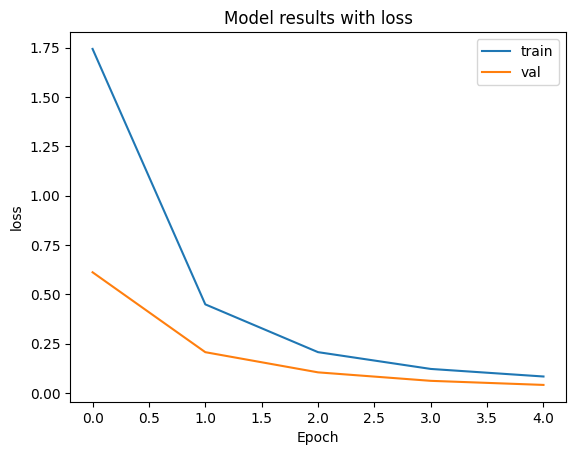

In [75]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

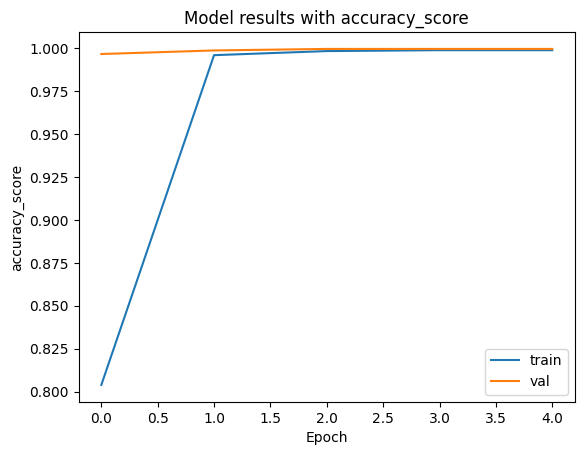

In [76]:
plot_metric(history, 'accuracy_score')

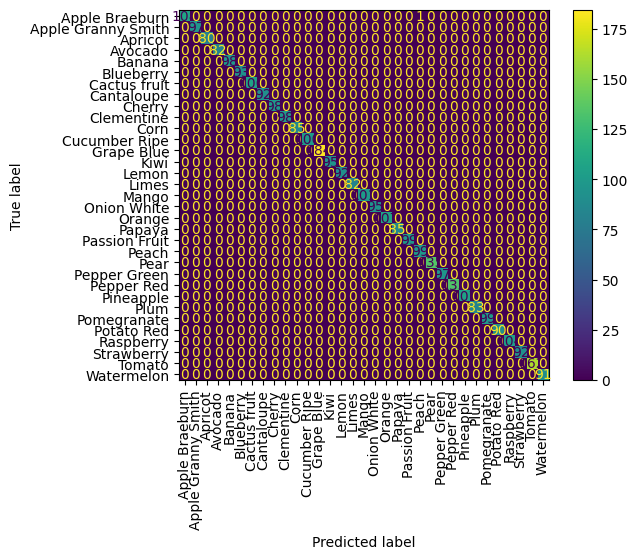

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay

model = model.to('cpu')  # переключаем модель на использование ЦП
model.eval()

batch_size = 102 
loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

y_true = []
y_pred = []

for X_batch, y_batch in loader:
    batch_pred = model.predict(X_batch)
    
    y_true.extend(y_batch.tolist())
    y_pred.extend(batch_pred.argmax(-1).tolist())

display_labels = dataset_trains.classes

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=display_labels)
plt.xticks(rotation=90)
plt.show()